# Using mhdx_tools Part 1: Preprocessing
***

**The purpose of this notebook is to provide explanation and usage examples for the modules of the preprocessing subpackage of the mhdx_tools package.**

>The preprocessing subpackage is used to search HDX-LC-IMS-MS data for signal that could plausibly correspond to known-injected-protein sequences. The final product of the Preprocessing subpackage is library_info.csv, a list of observed charged-species from the data that reasonably correspond to expected values for library proteins.

**The preprocessing modules are the start of the analytical pipeline and require a set of initial inputs:**
1. .mzML files generated from Waters .RAW files for all replicates of all hdx time points. ProteoWizard msconvert is used for conversion. 
2. .peaks.isotopes files generated with IMTBX+Grppr from all .mzML replicates of the undeuterated hdx-timepoint, not yet available as a Docker image - windows only
3. A .csv file of all library proteins with 'name' and 'sequence' columns, with sequences in single-letter amino acid notation.
4. A dictionary (.yaml if using Snakemake or command-line) with the key 'timepoints' corresponding to a list of the hdx time points in integer seconds, and where each integer entry in 'timepoints' is a key corresponding to the filepaths for all replicate .mzML files for that time point. 

**These inputs are used by the modules of the preprocessing subpackage to generate several intermediate files which are used to generate the library_info.csv master list of identified library protein charged-species and their positions within each dimension of separation:**
-  Total Ionic Current (tic) files for all hdx time point replicate .mzML files, used with dynamic time-warping to estimate LC-elution times in later hdx time points.
-  .csv lists of library protein charge-states observed for each imtbx .peaks.isotopes file

**The master list is created from initial inputs and the above intermediates, and it is fed forward as input to the pipeline modules along with gzipped versions of the .mzML files.**

In [2]:
import os
import sys
import yaml
import glob
import numpy as np
import pandas as pd
import seaborn as sns

# Set matplotlib backend to work in jupyter
import matplotlib
# matplotlib.use("nbAgg") # best for windows but works on Mac
matplotlib.use("MacOSX") # best for notebooks on Mac
import matplotlib.pyplot as plt
%matplotlib inline

# Make the Jupyter environment see workflow/scripts/.
sys.path.append("/".join(os.getcwd().split("/")[:-1])+"/workflow/scripts") # default 'path/to/mhdx_tools-Pipeline/workflow/scripts/'
config = yaml.load(open("../config/config.yaml", "rb").read(), Loader=yaml.FullLoader)

# Load and alias main functions of preprocessing modules
from mhdx_tools.preprocessing.imtbx_reader import main as imtbx_reader
from mhdx_tools.preprocessing.make_ims_mz_tics import main as make_ims_mz_tics
from mhdx_tools.preprocessing.gzip_mzml import main as gzip_mzml
from mhdx_tools.preprocessing.make_library_master_list import main as make_library_master_list

from mhdx_tools.io import limit_read, limit_write

***

## Making Total Ionic Current (TIC) representations

Our identification assumes that LC-elution and IMS-drift times will be near-invariate over the course of the HDX time series, and we use this to compensate for uncertainty in mass when identifying at later HDX time points. 

LC-elution order is assumed to be preserved between runs, but not elution-time. We use the fastdtw dynamic time-warping algorithm to map from the undeuterated ground-truth elution times to the unknown elution times of the later HDX time points.

We downsample the undeuterated .mzML files into .tic files to lower the expense of the dynamic time-warping algorithm used to map undeuterated LC-profiles to later timepoints.

In [3]:
help(make_ims_mz_tics)

Help on function main in module mhdx_tools.preprocessing.make_ims_mz_tics:

main(mzml_path, return_flag=None, out_path=None)
    Generate LC Chromatogram by summing ionic current over IMS and m/Z dimensions.
    
    Args:
        mzml_path (string): path/to/file.mzml to be read into .tic
        return_flag: option to return main output in python, for notebook context
        out_path (string): option to save main output, path/to/file.tic
    
    Returns:
        ms1_ims_tic (np_array): LC Chromatogram as 2D numpy ndarray. Contains sum of ionic current for LC-RT and m/Z bins.



In [4]:
# Generate a .tic file for an undeuterated timepoint if it's not already present.
if "../resources/tics/180604_Mix2_MES_nonlin_UN.mzML.ims.mz.tic" not in glob.glob("../resources/tics/*.tic"):
    un_tic = make_ims_mz_tics("../resources/mzml/180604_Mix2_MES_nonlin_UN.mzML", out_path="../resources/tics/180604_Mix2_MES_nonlin_UN.mzML.ims.mz.tic", return_flag=True)
else:
    un_tic = np.loadtxt("../resources/tics/180604_Mix2_MES_nonlin_UN.mzML.ims.mz.tic")

[Text(0.5, 69.0, 'Liquid chromatography (LC) elution time bins'),
 Text(123.0, 0.5, 'Mass/Charge (m/Z) bins')]

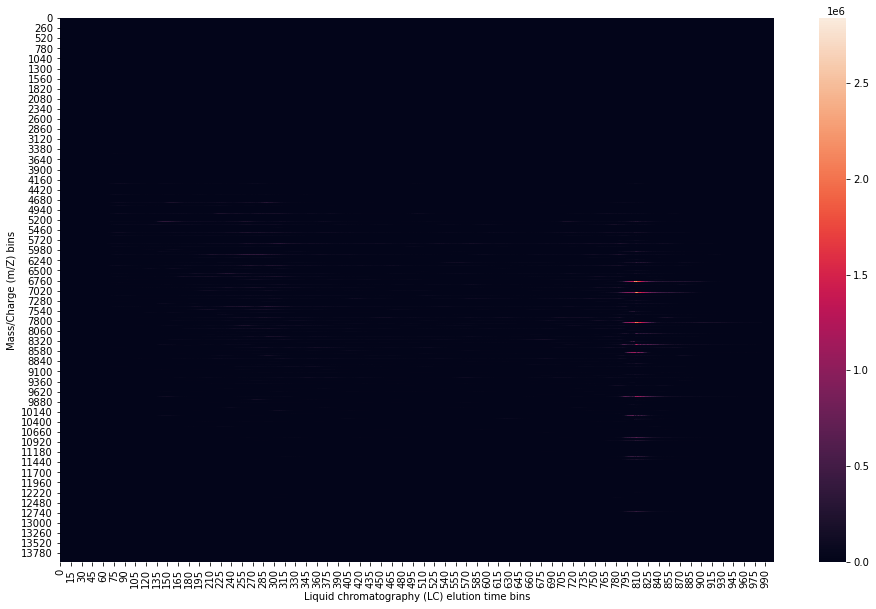

In [5]:
# The downsampled .tic will be used to map the LC-elution profiles of each later timepoint replicate to the undeuterated ground-truth values.
# The heatmap will be mostly dark because of the ~1e6 magnitude of the abundant protein signals.
# Dimensions of tic are LC-bins and m/Z bins
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(111)
ax1 = sns.heatmap(un_tic, ax=ax1)
ax1.set(xlabel="Liquid chromatography (LC) elution time bins", ylabel = "Mass/Charge (m/Z) bins")

***
## Making identification lists from imtbx .peaks.isotopes files

IMTBX + Grppr produce the .peaks.isotopes file, which is a list of observed peaks and their positions for a single undeuterated .mzML file. 

We cross-reference this list of all charged species signals with the expected masses of library proteins. 

The filtered .peaks.isotopes entries are returned as a Pandas-ready dictionary (.csv in snakemake and command-line) and the undeuterated lists are combined in the make_library_master_list module. 

In [6]:
help(imtbx_reader)

Help on function main in module mhdx_tools.preprocessing.imtbx_reader:

main(isotopes_path, names_and_seqs_path, out_path=None, return_flag=None, original_mz_kde_path=None, adjusted_mz_kde_path=None, calibration_outpath=None, polyfit_deg=1, ppm_tolerance=50, intensity_tolerance=10000, cluster_corr_tolerance=0.99, ppm_refilter=10)
    Reads IMTBX file and clusters identified signals with close physical values. 
    
    Args:
        isotopes_path (string): path/to/.peaks.isotopes file from undeuterated mzml
        names_and_seqs_path (string): path/to/.csv with names and sequences of library proteins
        out_path (string): path/to/_intermediate.csv main output file
        return_flag (non-None): option to return main output in Python, for notebook context
        original_mz_kde_path (string): /path/to/file to save original mz-error kde plots
        adjusted_mz_kde_path (string): /path/to/file to save adjusted mz-error kde plots
        calibration_outpath (string): /path/to/fil

/Users/rwl0960/opt/anaconda3/envs/dask_lab/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



No rt Duplicates: True


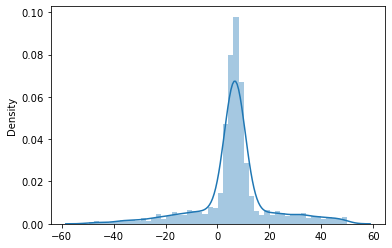

In [16]:
# Generate the 0th undeuterated imtbx intermediate file if it's not already present.
if "../resources/imtbx/180604_Mix2_MES_nonlin_UN.mzML_intermediate.csv" not in glob.glob("../resources/imtbx/*.csv"):
    imtbx_intermediate_UN = pd.DataFrame.from_dict(imtbx_reader("../resources/isotopes/180604_Mix2_MES_nonlin_UN.mzML.peaks.isotopes", "../resources/library_info/new_HX_order.csv", out_path="../resources/imtbx/180604_Mix2_MES_nonlin_UN.mzML_intermediate.csv", return_flag=True))
else:
    imtbx_intermediate_UN = pd.read_csv("../resources/imtbx/180604_Mix2_MES_nonlin_UN.mzML_intermediate.csv")

In [17]:
imtbx_intermediate_UN

,name,RT,im_mono,ab_cluster_total,MW,charge,expect_mz,obs_mz,ppm,abs_ppm,cluster
0,HEEH_rd1_0125.pdb,4.458056,116.508605,3010934.8,5238.760347,5.0,1048.759339,1048.758083,-1.2,1.197974,111
1,HHH_rd4_0891.pdb,4.349178,118.225656,207025.7,5649.892150,5.0,1130.985700,1130.985611,-0.1,0.079082,139
2,HEEH_rd1_0125.pdb,4.439518,89.788979,703478.1,5238.760347,6.0,874.133994,874.131069,-3.3,3.346653,162
3,HEEH_rd1_0966.pdb,4.384746,101.893880,476410.9,5648.896896,6.0,942.490086,942.488971,-1.2,1.183368,167
4,HEEH_rd1_0966.pdb,4.406459,118.695357,258016.0,5648.896896,5.0,1130.786649,1130.789337,2.4,2.376841,228
...,...,...,...,...,...,...,...,...,...,...,...
1876,HEEH_rd4_0276.pdb,18.797200,102.958674,252871.5,5071.781584,6.0,846.304201,846.300142,-4.8,4.795363,7097
1877,HEEH_rd4_0276.pdb,18.824251,90.896216,199883.9,5071.781584,6.0,846.304201,846.300228,-4.7,4.693881,7100
1878,HHH_rd1_0014.pdb,18.717667,124.237793,306718.5,6124.201519,5.0,1225.847574,1225.853444,4.8,4.788921,7102
1879,HEEH_rd4_0528.pdb,19.364049,182.543280,276702.2,4958.772975,4.0,1240.700514,1240.702833,1.9,1.869200,7115


/Users/rwl0960/opt/anaconda3/envs/dask_lab/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



No rt Duplicates: True


/Users/rwl0960/opt/anaconda3/envs/dask_lab/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



No rt Duplicates: True


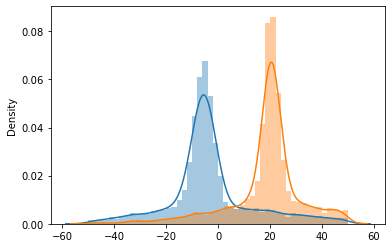

In [20]:
# Make any missing imtbx intermediate files.
imtbx_intermediates = glob.glob("../resources/imtbx/*.csv")
for mzml in config[0]:
    if not any(mzml in fn for fn in imtbx_intermediates):
        imtbx_reader("../resources/isotopes/"+mzml+".peaks.isotopes", "../resources/library_info/new_HX_order.csv", out_path="../resources/imtbx/"+mzml+"_intermediate.csv")

***
## Making the master list of library protein signals

The main output of the preprocessing subpackage is library_info.csv:<br>
>A list of all signals observed in the undeuterated MS experiments with masses corresponding to library proteins and their expected locations in LC elution time at later HDX timepoints. 

The master list is created from the imtbx intermediate lists of identified signals, and TICs of each MS-run. The lists are combined and filtered for duplicates, and the TICs are used in prediction of LC-elution time for deuterated timepoints.

In [21]:
help(make_library_master_list)

Help on function main in module mhdx_tools.preprocessing.make_library_master_list:

main(names_and_seqs_path, undeut_mzml, intermediates, tics, timepoints, return_flag=None, out_path=None, rt_group_cutoff=0.2, plot=None)
    Generates the master list of library_proteins identified in MS data: library_info.csv.
    
    Args:
        names_and_seqs_path (string): path/to/names_and_seqs.csv
        undeut_mzml (string): path/to/undeuterated.mzML
        intermediates (list of strings): list of paths to imtbx intermediate files
        tics (list of strings): list of paths to all .tic files
        timepoints (dict): dictionary with 'timepoints' key containing list of hdx timepoints in integer seconds, which are keys mapping to lists of each timepoint's replicate .mzML filenames 
        return_flag (any non-None type): option to return main output in python, for notebook context
        out_path (string): path/to/file for main output library_info.csv
        rt_group_cutoff (float): radi

In [22]:
intermediates = ["../resources/imtbx/180604_Mix2_MES_nonlin_UN.mzML_intermediate.csv", 
                 "../resources/imtbx/180604_Mix2_MES_nonlin_UN2.mzML_intermediate.csv", 
                 "../resources/imtbx/180604_Mix2_MES_nonlin_UN3.mzML_intermediate.csv"]
tics = glob.glob("../resources/tics/*")

/Users/rwl0960/opt/anaconda3/envs/dask_lab/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning:

Mean of empty slice.

/Users/rwl0960/opt/anaconda3/envs/dask_lab/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/Users/rwl0960/Documents/hdx/mhdx_tools-Pipeline/workflow/scripts/mhdx_tools/preprocessing/make_library_master_list.py:343: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/rwl0960/Documents/hdx/mhdx_tools-Pipeline/workflow/scripts/mhdx_tools/preprocessing/make_library_master_list.py:345: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

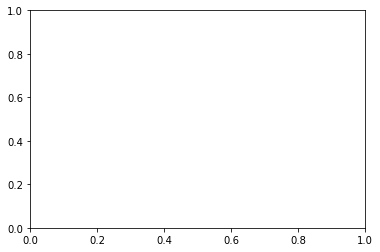

In [23]:
# This can take a long time to run depending on the number of identifications from imtbx.
test_library_info = pd.DataFrame.from_dict(make_library_master_list("../resources/library_info/new_HX_order.csv", "../resources/mzml/180604_Mix2_MES_nonlin_UN.mzML", intermediates, tics, config, return_flag=True, out_path="../resources/library_info/test_library_info.csv"))

In [25]:
test_library_info

{'name': {0: 'HEEH_rd3_0224.pdb_4.24223',
  1: 'HEEH_rd3_0224.pdb_4.24223',
  2: 'HEEH_rd1_0966.pdb_4.24223',
  3: 'HEEH_rd1_0966.pdb_4.24223',
  4: 'HEEH_rd1_0966.pdb_4.24223',
  5: 'HEEH_rd1_0966.pdb_4.24223',
  6: 'EEHEE_rd4_1000.pdb_4.27206',
  7: 'HEEH_rd1_0125.pdb_4.28798',
  8: 'HEEH_rd1_0125.pdb_4.28798',
  9: 'HEEH_rd1_0125.pdb_4.28798',
  10: 'HEEH_rd1_0125.pdb_4.28798',
  11: 'HEEH_rd1_0125.pdb_4.28798',
  12: 'HHH_rd4_0891.pdb_4.33174',
  13: 'EEHEE_rd4_0565.pdb_4.4312',
  14: 'HEEH_rd1_0092.pdb_4.49088',
  15: 'HEEH_rd1_0966.pdb_4.51077',
  16: 'HEEH_rd1_0884.pdb_4.51575',
  17: 'HEEH_rd1_0884.pdb_4.51575',
  18: 'HEEH_rd1_0884.pdb_4.51575',
  19: 'HEEH_rd1_0884.pdb_4.51575',
  20: 'EEHEE_rd4_0934.pdb_4.53067',
  21: 'HEEH_rd1_0125.pdb_4.53067',
  22: 'HEEH_rd1_0125.pdb_4.53067',
  23: 'HEEH_rd1_0125.pdb_4.53067',
  24: 'HHH_rd4_0891.pdb_4.57045',
  25: 'EEHEE_rd1_0229.pdb_4.58537',
  26: 'EEHEE_rd1_0229.pdb_4.58537',
  27: 'EEHEE_rd1_0229.pdb_4.58537',
  28: 'EEHEE_rd1_02

***
## Gzipping .mzMLs

The mhdx_tools.preprocessing.gzip_mzml module is a wrapper script for the pymzml.utils.utils.index_gzip function, which saves a .mzML file in a randomly accessible format. 

These .mzML.gz files are used when extracting the identified signals from their expected locations in the pipeline subpackage.

In [60]:
help(gzip_mzml)

Help on function main in module mhdx_tools.preprocessing.gzip_mzml:

main(mzml_path, out_path=None)
    Create an indexed, gzipped mzML.gz file from a .mzML file.
    
    Args:
        mzml_path (string): path/to/file.mzML to be gzipped 
        out_path (string): path/to/file.mzML.gz - the gzipped .mzML output path
    
    Returns:
        None



In [ ]:
# Does not return
gzip_mzml(mzml_path='', outpath='')